# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Logística

### Import required libraries and dataset

In [488]:
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
from os.path import exists

In [489]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [490]:
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import tensorflow_addons as tfa

In [491]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Download and load Fashion MNIST dataset

In [492]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

### Normalize the dataset

In [493]:
data_max = np.max(train_X)
train_X = train_X.astype('float32') / data_max
test_X = test_X.astype('float32') / data_max
np.max(train_X)

1.0

### Exploratory Data Analysis

#### Example: Show the first object of the train dataset

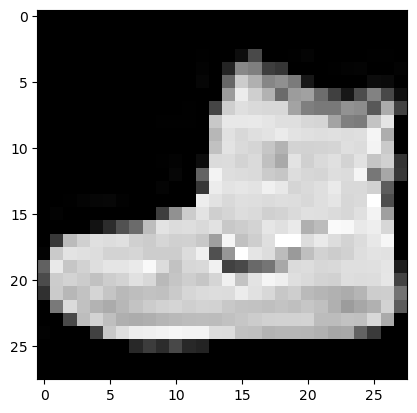

In [494]:
plt.imshow(train_X[0,...], cmap="gray")

#### Show a few instances of each class

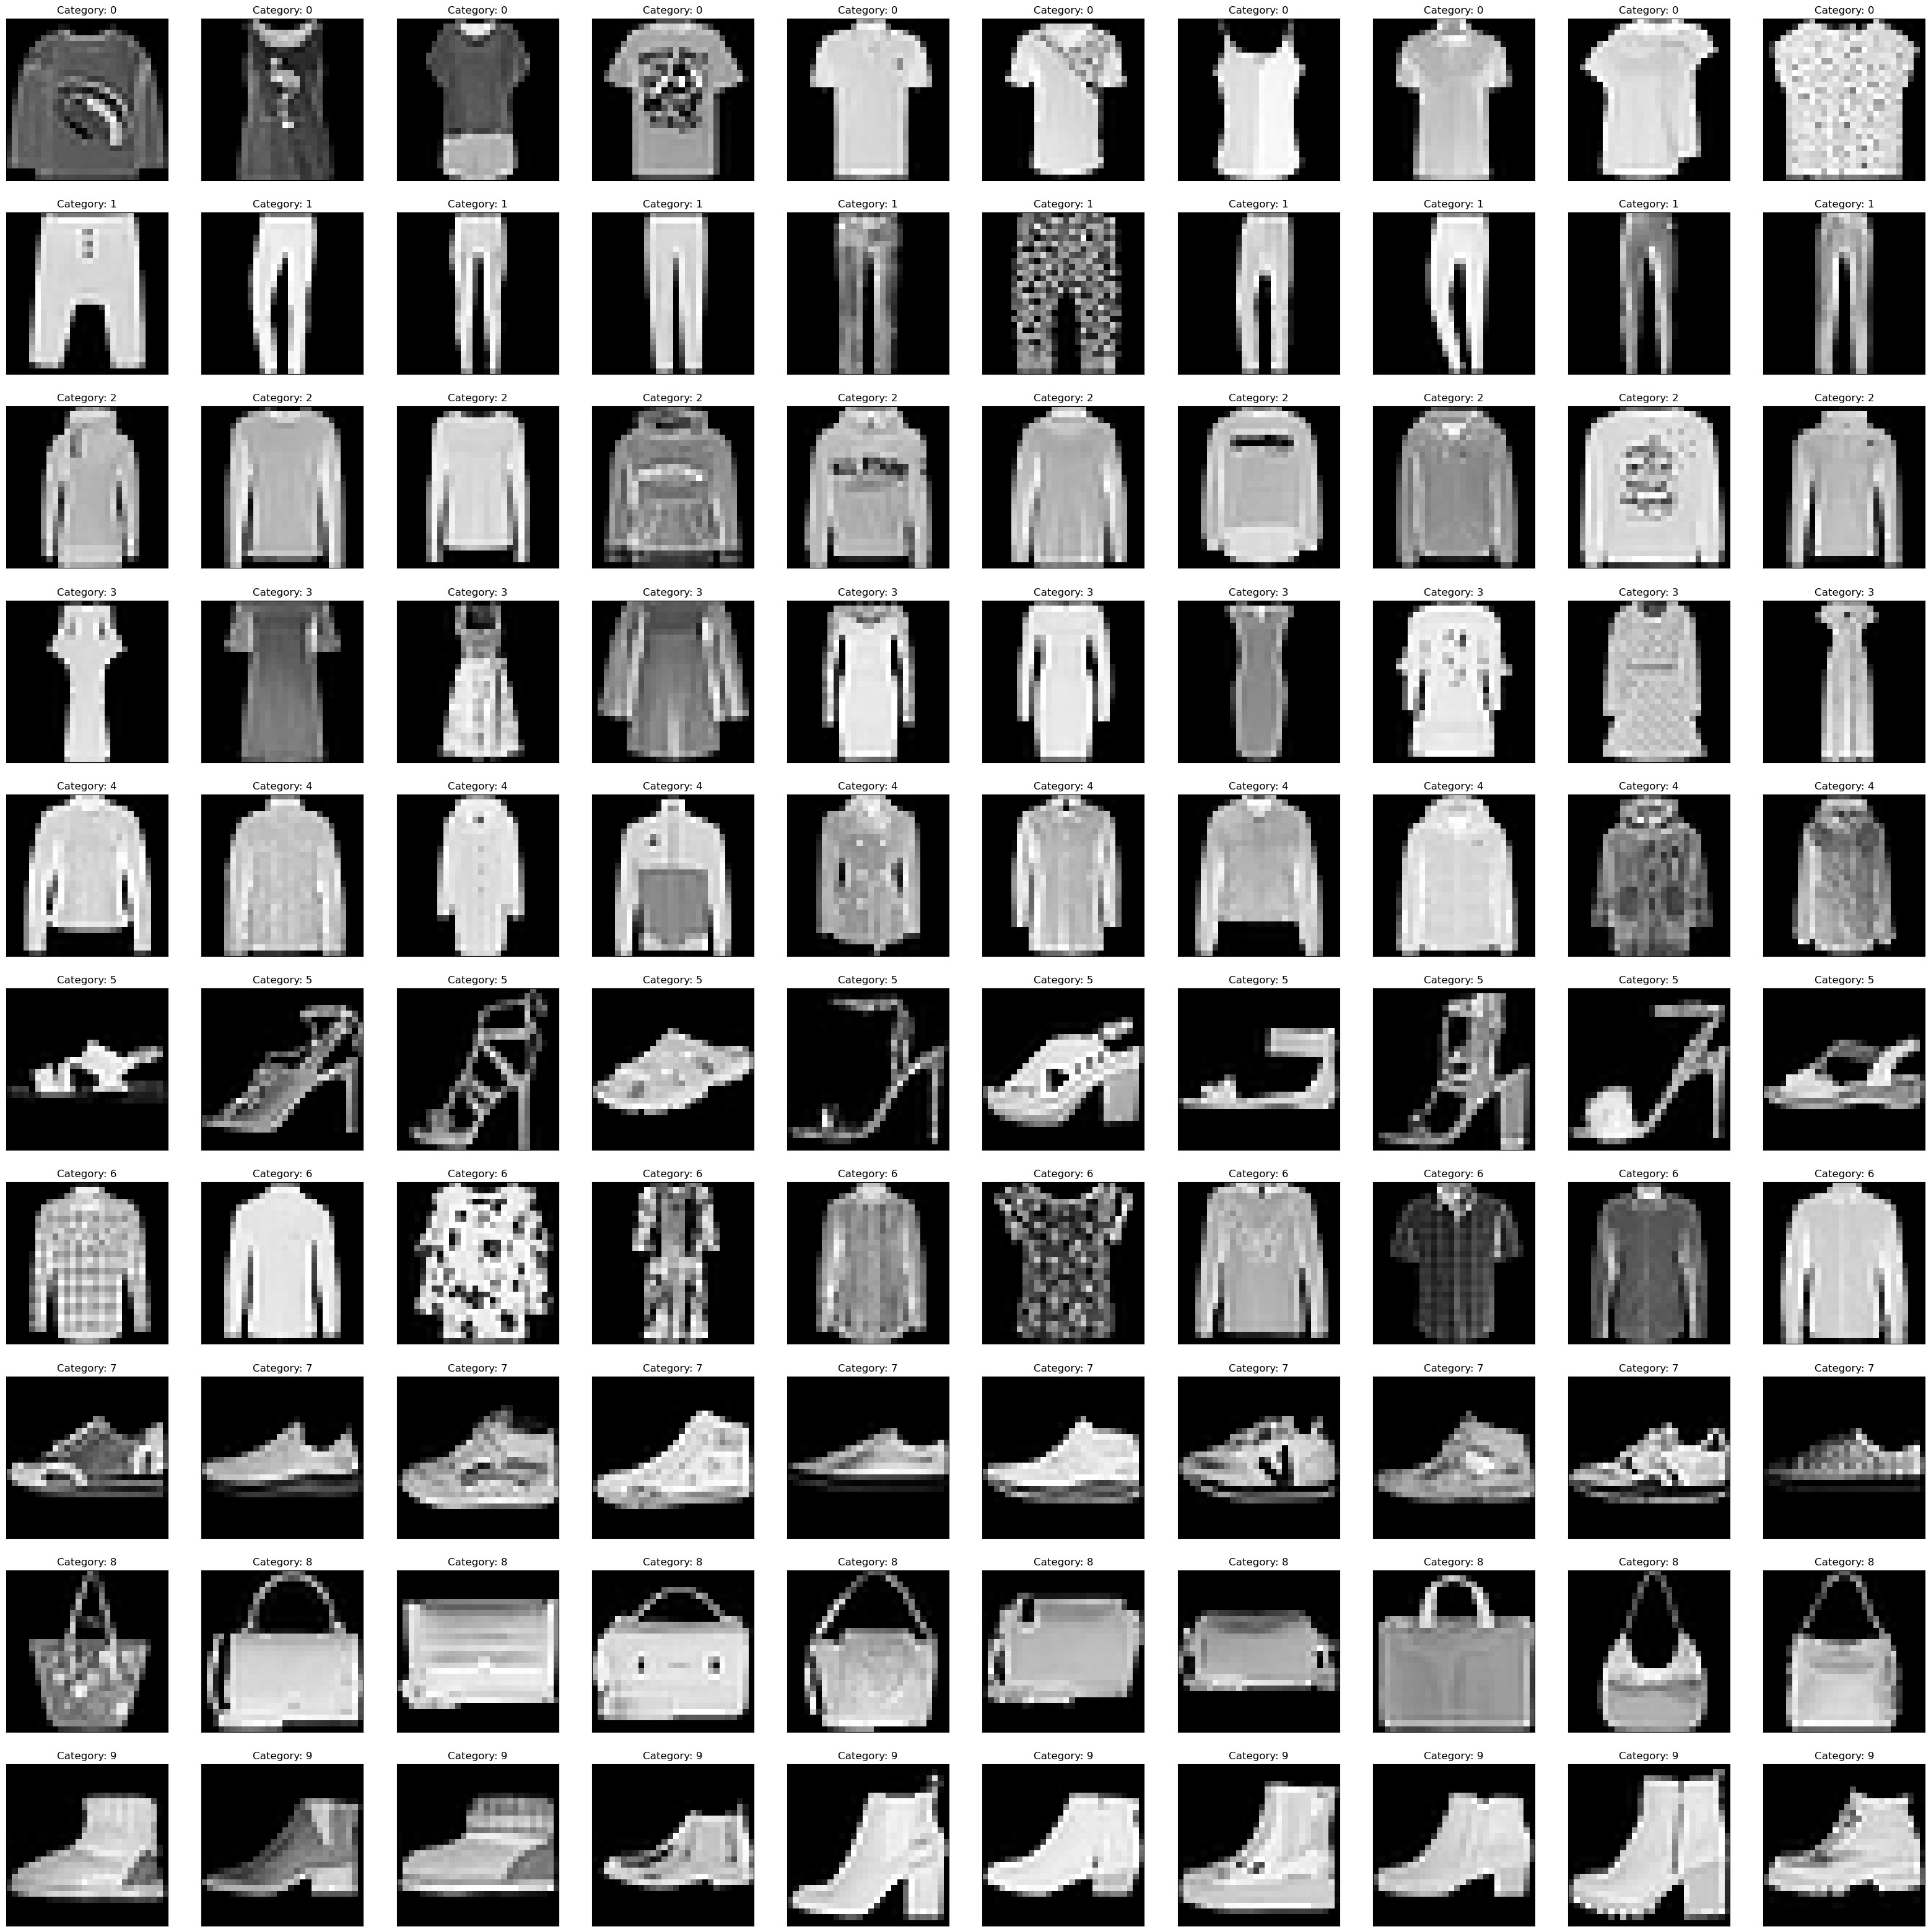

In [495]:
fig = plt.figure(figsize=(40, 40))  # width, height in inches

# idx works on np.array and not lists.
idx = np.argsort(train_y)

train_X_sorted = np.array(train_X)[idx]
train_y_sorted = np.array(train_y)[idx]

count = 0

for i in range(100):
    count = int(np.floor(i / 10))
    sub = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    sub.imshow(train_X_sorted[i + count * 6000,:,:], interpolation='nearest', cmap='gray')
    sub.set_title('Category: ' + str(train_y_sorted[i + count * 6000]))

#### Look at the data distribution

##### Training data

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


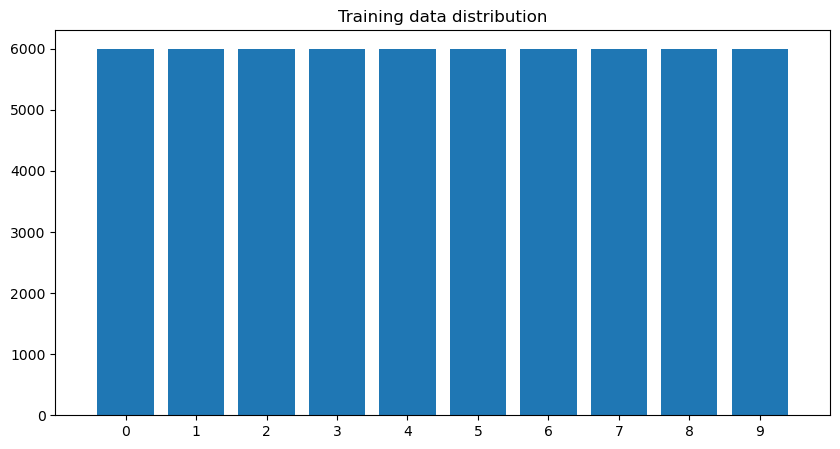

In [496]:
unique, counts = np.unique(train_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(train_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()

##### Testing data

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


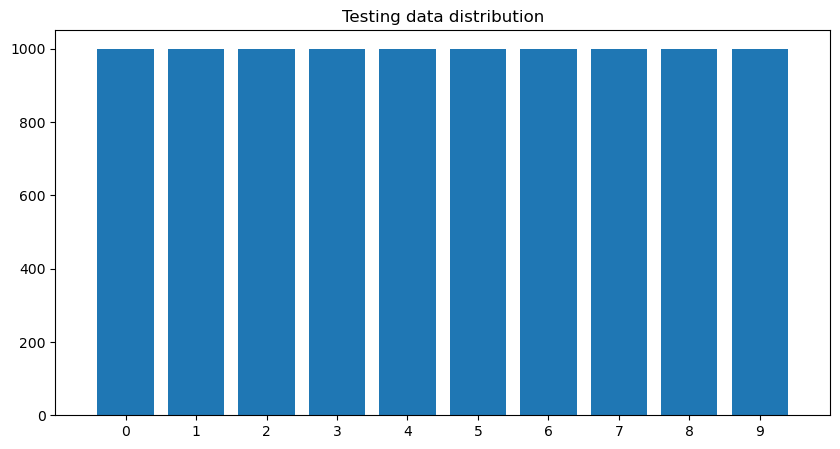

In [497]:
unique, counts = np.unique(test_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(test_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Testing data distribution')

plt.show()

### Convert the dataset from a vector form to a categorical distribution

In [498]:
num_classes = np.max(train_y) + 1
train_y_cat = utils.to_categorical(train_y, num_classes)
test_y_cat = utils.to_categorical(test_y, num_classes)

### Softmax

#### Config the model to be trained

In [499]:
#train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32')
#test_X = test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32')

In [500]:
softmax_model =  Sequential()
#model.add(preprocessing.RandomFlip("horizontal", input_shape=(28,28,1)))
# model.add(layers.Dropout(0.1, input_shape=(28,28)))
softmax_model.add(layers.Flatten(input_shape=(28,28)))
softmax_model.add(layers.Dense(128, activation="relu"))
softmax_model.add(layers.Dense(num_classes, activation="softmax"))
softmax_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_53 (Dense)            (None, 128)               100480    
                                                                 
 dense_54 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In [501]:
softmax_model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=0.0002, momentum=0.95),metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [502]:
# Callback to stop training if, after 2 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [503]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/softmax'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [504]:
# Logs and metrics from TensorBoard
log_dir = "logs/fit/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### Fit the model to the train data and validate it with the test data

In [505]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath)):
    # softmax_model.load_weights(checkpoint_filepath)

In [506]:
softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[tensorboard_callback, early_stop_callback])
# softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

Epoch 1/10
938/938 [==============================] - 10s 10ms/step - loss: 1.1546 - accuracy: 0.6424 - f1_score: 0.6143 - f1_score_micro: 0.6424 - precision: 0.8985 - recall: 0.3285 - val_loss: 0.8236 - val_accuracy: 0.7258 - val_f1_score: 0.7153 - val_f1_score_micro: 0.7258 - val_precision: 0.8777 - val_recall: 0.5208
Epoch 2/10
938/938 [==============================] - 10s 10ms/step - loss: 0.7308 - accuracy: 0.7607 - f1_score: 0.7533 - f1_score_micro: 0.7607 - precision: 0.8724 - recall: 0.5911 - val_loss: 0.6900 - val_accuracy: 0.7687 - val_f1_score: 0.7627 - val_f1_score_micro: 0.7687 - val_precision: 0.8678 - val_recall: 0.6295
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.6391 - accuracy: 0.7903 - f1_score: 0.7862 - f1_score_micro: 0.7903 - precision: 0.8745 - recall: 0.6641 - val_loss: 0.6296 - val_accuracy: 0.7871 - val_f1_score: 0.7842 - val_f1_score_micro: 0.7871 - val_precision: 0.8666 - val_recall: 0.6768
Epoch 4/10
938/938 [==============

#### Plot important metrics

##### TensorBoard session

In [507]:
%tensorboard --logdir logs/fit

##### Loss

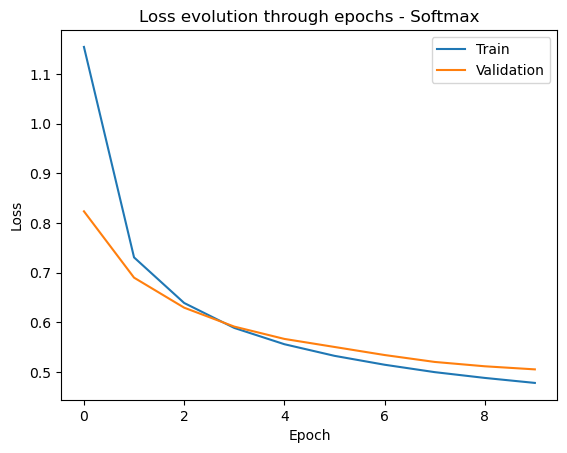

In [508]:
plt.plot(softmax_history.history["loss"], label="Train")
plt.plot(softmax_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - Softmax')
plt.show()

##### Accuracy

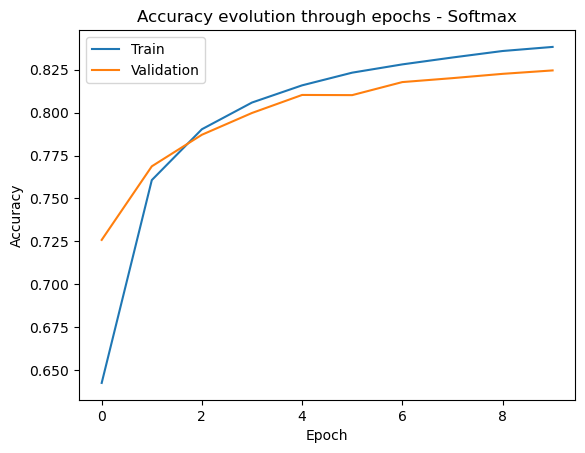

In [509]:
plt.plot(softmax_history.history["accuracy"], label="Train")
plt.plot(softmax_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - Softmax')
plt.show()

##### Precision

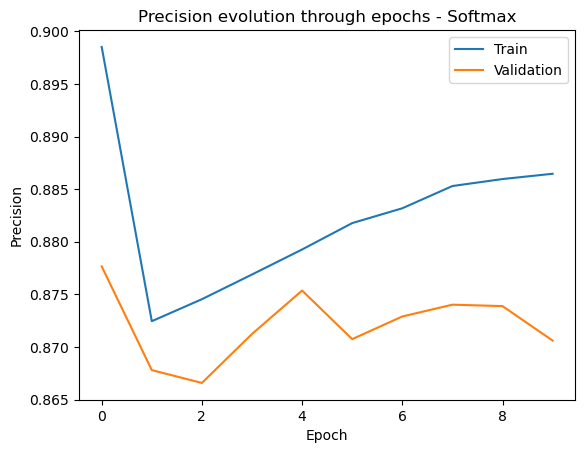

In [510]:
plt.plot(softmax_history.history["precision"], label="Train")
plt.plot(softmax_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - Softmax')
plt.show()

##### Recall

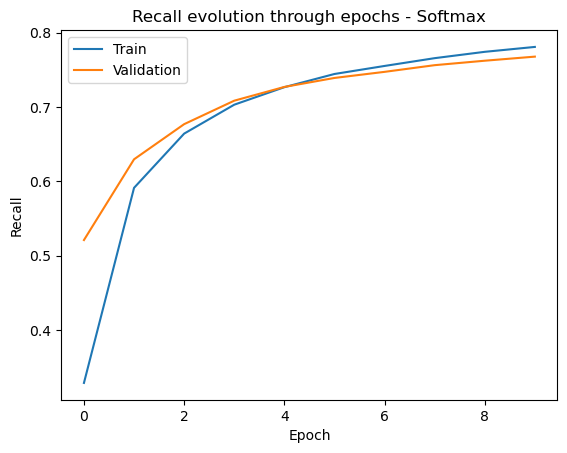

In [511]:
plt.plot(softmax_history.history["recall"], label="Train")
plt.plot(softmax_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - Softmax')
plt.show()

##### F1-Score

###### Macro

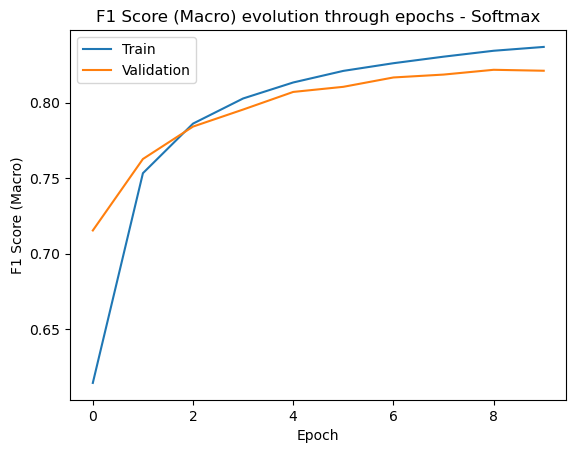

In [512]:
plt.plot(softmax_history.history["f1_score"], label="Train")
plt.plot(softmax_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - Softmax')
plt.show()

###### Micro

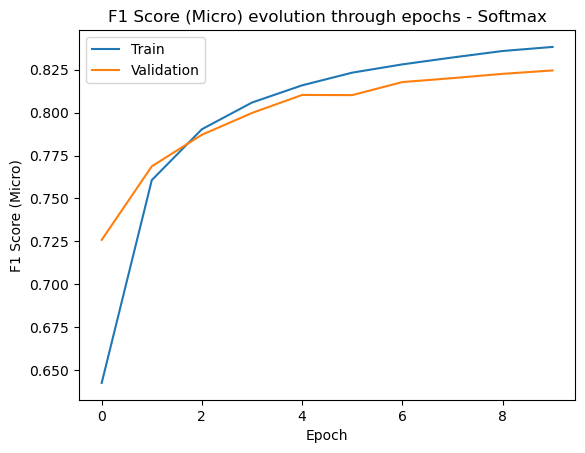

In [513]:
plt.plot(softmax_history.history["f1_score_micro"], label="Train")
plt.plot(softmax_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - Softmax')
plt.show()

##### ROC and AUC

313/313 [==============================] - 1s 2ms/step


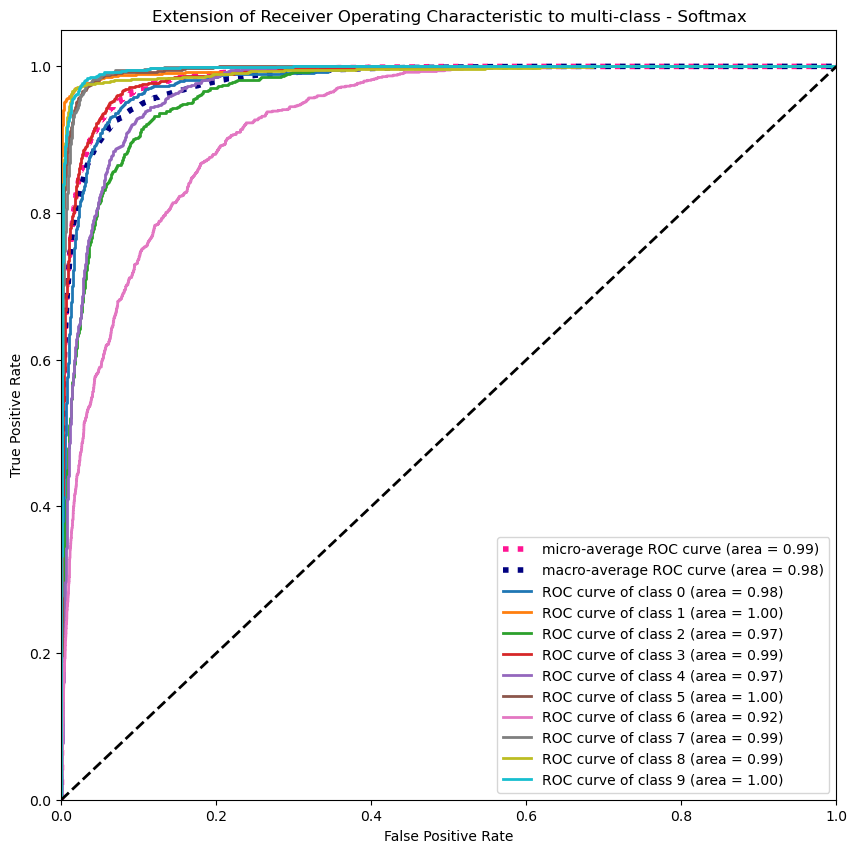

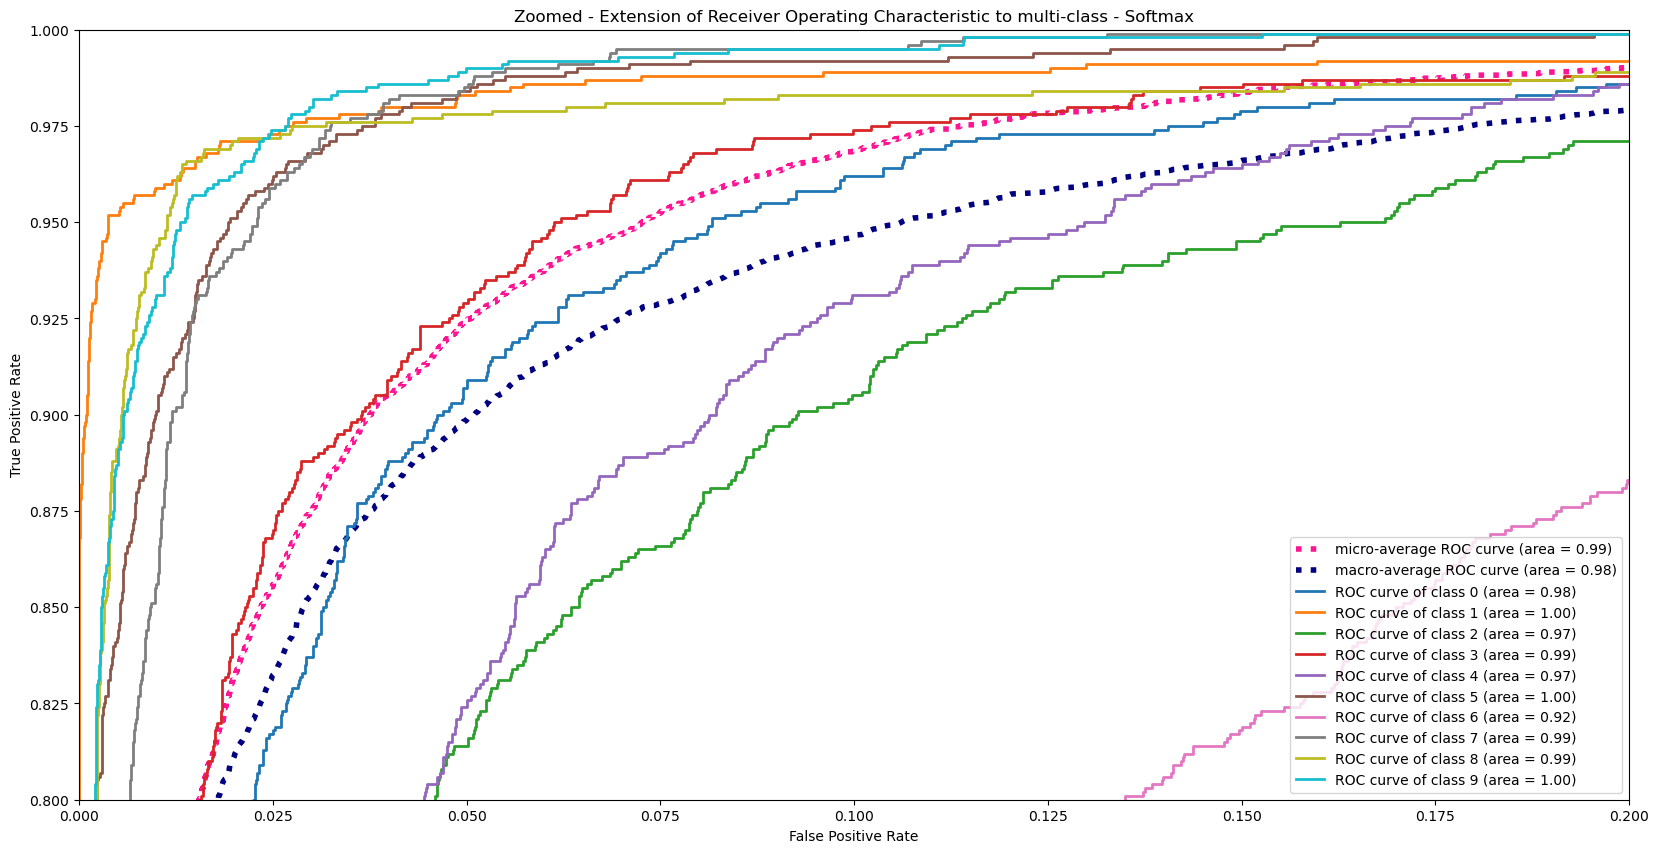

In [514]:
# Plot linewidth.
lw = 2

# Get score
y_score = softmax_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))
    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

### MLP

In [515]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.Dense(256, activation='relu'))
mlp_model.add(layers.Dense(64, activation='relu'))
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_55 (Dense)            (None, 256)               200960    
                                                                 
 dense_56 (Dense)            (None, 64)                16448     
                                                                 
 dense_57 (Dense)            (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In [516]:
mlp_model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=0.0002, momentum=0.95),metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [517]:
# Callback to stop training if, after 2 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [518]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/mlp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [519]:
# Logs and metrics from TensorBoard
log_dir = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### Fit the model to the train data and validate it with the test data

In [520]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath)):
    # mlp_model.load_weights(checkpoint_filepath)

In [521]:
mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[tensorboard_callback, early_stop_callback])
# softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])
# mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

Epoch 1/10
938/938 [==============================] - 10s 11ms/step - loss: 1.1837 - accuracy: 0.6370 - f1_score: 0.6148 - f1_score_micro: 0.6370 - precision: 0.8934 - recall: 0.3156 - val_loss: 0.7866 - val_accuracy: 0.7399 - val_f1_score: 0.7343 - val_f1_score_micro: 0.7399 - val_precision: 0.8684 - val_recall: 0.5479
Epoch 2/10
938/938 [==============================] - 10s 10ms/step - loss: 0.6886 - accuracy: 0.7716 - f1_score: 0.7667 - f1_score_micro: 0.7716 - precision: 0.8674 - recall: 0.6201 - val_loss: 0.6493 - val_accuracy: 0.7793 - val_f1_score: 0.7756 - val_f1_score_micro: 0.7793 - val_precision: 0.8612 - val_recall: 0.6584
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.5942 - accuracy: 0.8011 - f1_score: 0.7984 - f1_score_micro: 0.8011 - precision: 0.8749 - recall: 0.6976 - val_loss: 0.5874 - val_accuracy: 0.8019 - val_f1_score: 0.8007 - val_f1_score_micro: 0.8019 - val_precision: 0.8711 - val_recall: 0.7105
Epoch 4/10
938/938 [===============

#### Plot important metrics

##### TensorBoard session

In [522]:
%tensorboard --logdir logs/fit

##### Loss

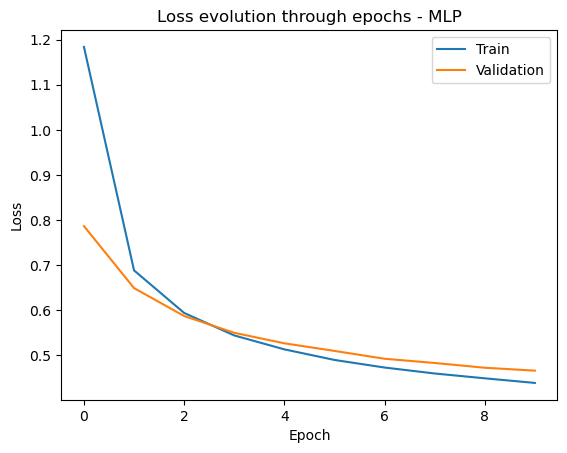

In [523]:
plt.plot(mlp_history.history["loss"], label="Train")
plt.plot(mlp_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - MLP')
plt.show()

##### Accuracy

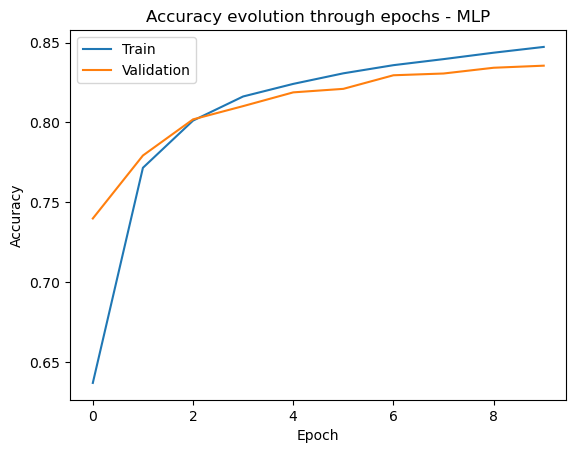

In [524]:
plt.plot(mlp_history.history["accuracy"], label="Train")
plt.plot(mlp_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - MLP')
plt.show()

##### Precision

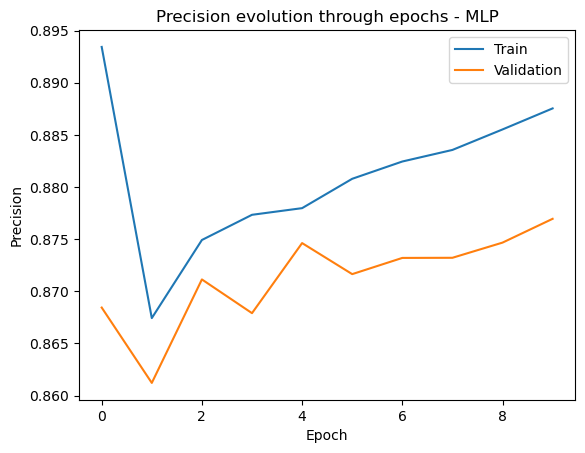

In [525]:
plt.plot(mlp_history.history["precision"], label="Train")
plt.plot(mlp_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - MLP')
plt.show()

##### Recall

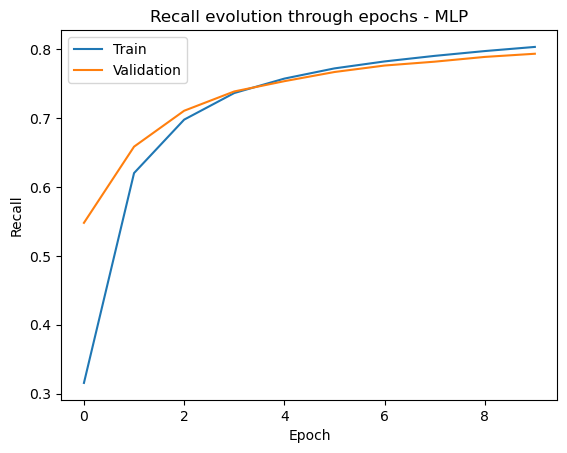

In [526]:
plt.plot(mlp_history.history["recall"], label="Train")
plt.plot(mlp_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - MLP')
plt.show()

##### F1 Score

###### Macro

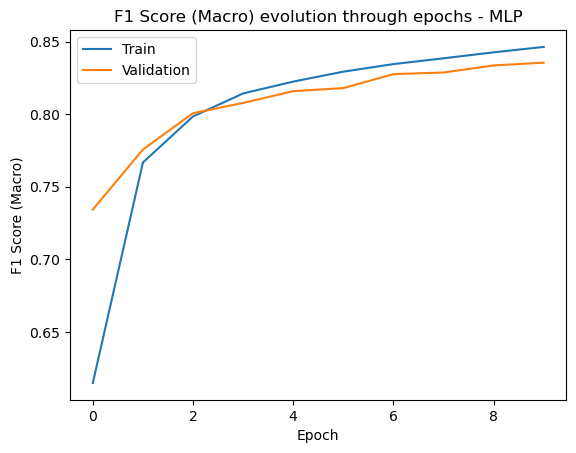

In [527]:
plt.plot(mlp_history.history["f1_score"], label="Train")
plt.plot(mlp_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - MLP')
plt.show()

###### Micro

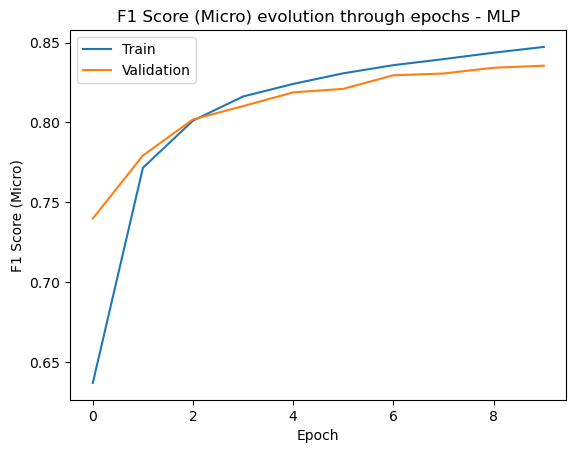

In [528]:
plt.plot(mlp_history.history["f1_score_micro"], label="Train")
plt.plot(mlp_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - MLP')
plt.show()

##### ROC and AUC

313/313 [==============================] - 1s 2ms/step


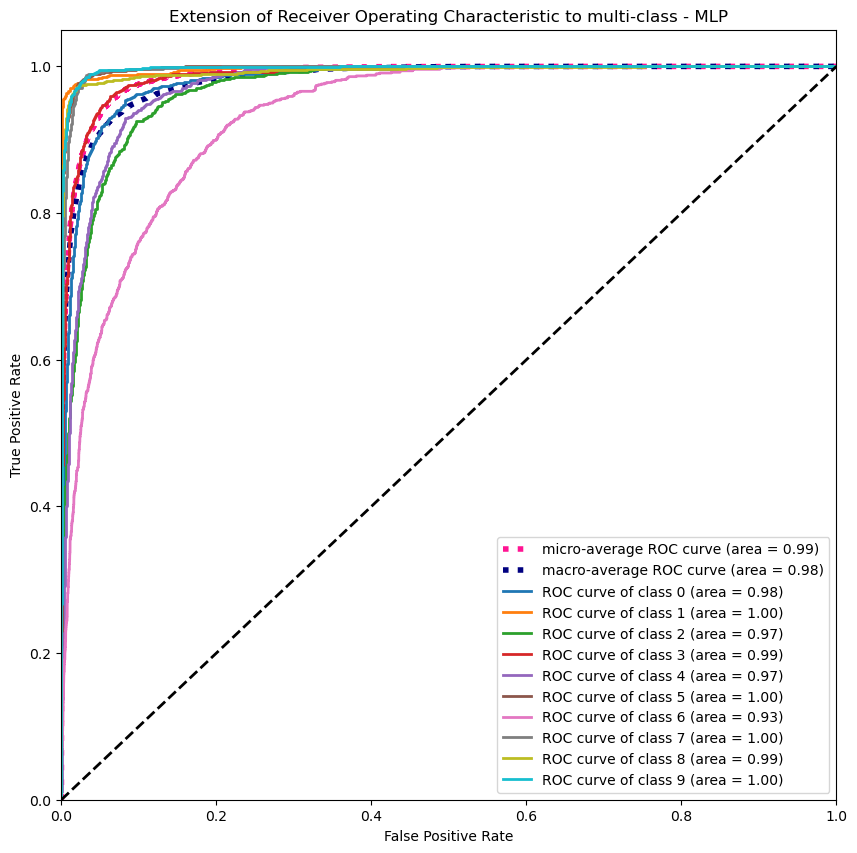

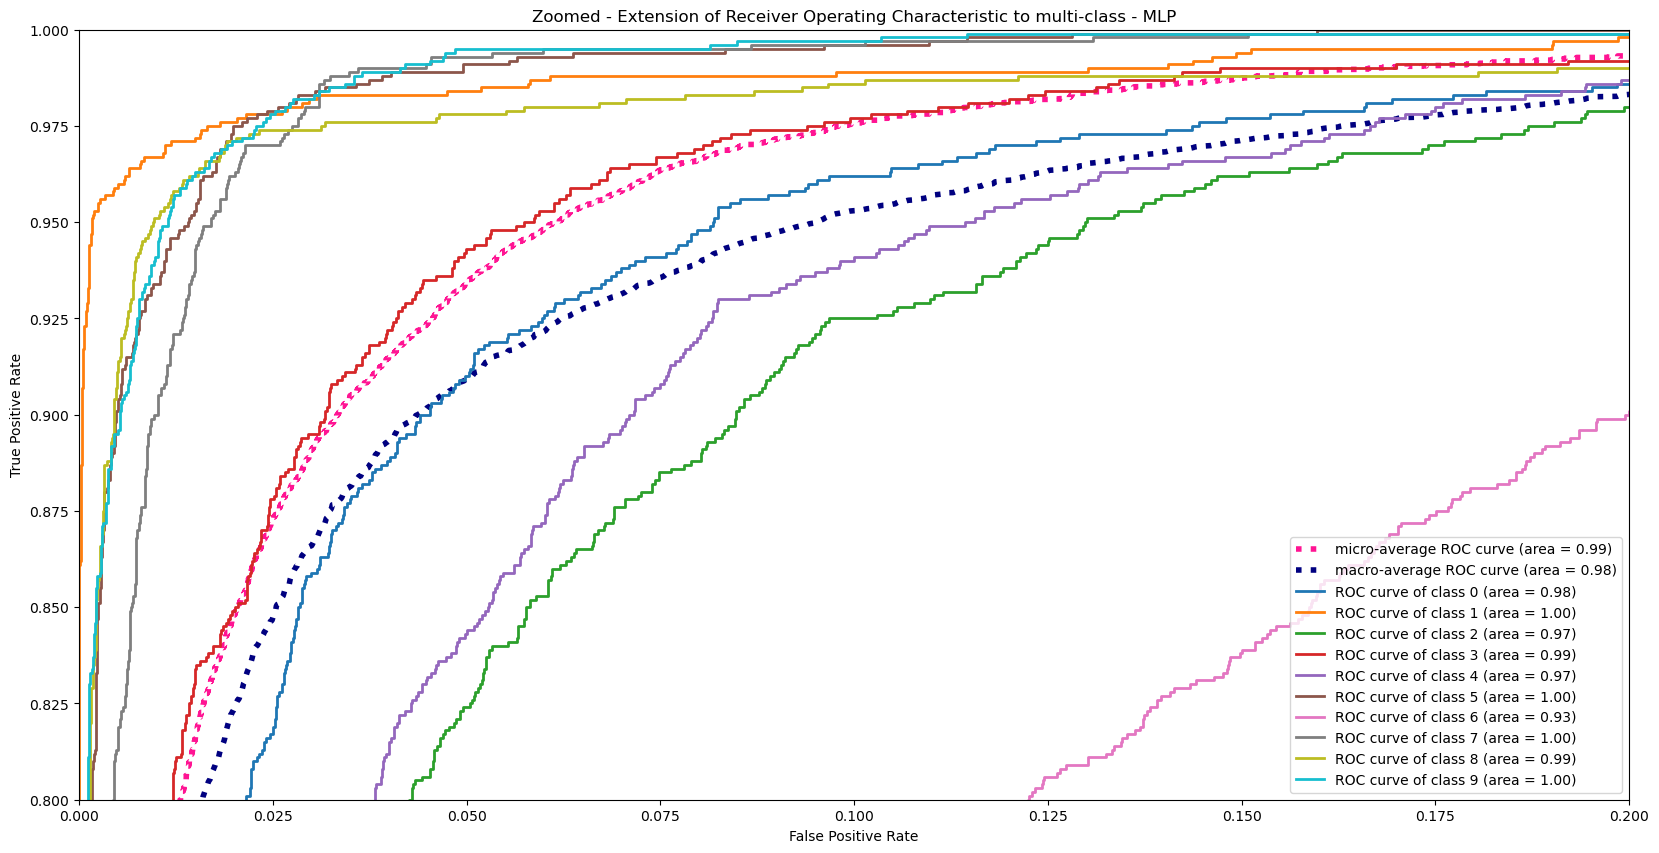

In [529]:
# Plot linewidth.
lw = 2

# Get score
y_score = mlp_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - MLP')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))
    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - MLP')
plt.legend(loc="lower right")
plt.show()